In [1]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import numpy as np
from shutil import copy2, move

from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from tqdm import tqdm
from torch.utils.data import Dataset
from torchvision.transforms import InterpolationMode

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import segmentation_models_pytorch as smp

from sklearn.metrics import jaccard_score
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt


In [2]:
!wget -O images.zip "https://zenodo.org/records/15298010/files/images.zip?download=1"

--2025-12-21 11:49:56--  https://zenodo.org/records/15298010/files/images.zip?download=1
Resolving zenodo.org (zenodo.org)... 188.185.48.75, 137.138.52.235, 188.185.43.153, ...
Connecting to zenodo.org (zenodo.org)|188.185.48.75|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1148063776 (1.1G) [application/octet-stream]
Saving to: ‘images.zip’

images.zip          100%[===================>]   1.07G  1.76MB/s    in 13m 5s  

2025-12-21 12:03:01 (1.40 MB/s) - ‘images.zip’ saved [1148063776/1148063776]



In [3]:
!wget -O mask.zip https://zenodo.org/records/15298010/files/masks.zip?download=1

--2025-12-21 12:03:23--  https://zenodo.org/records/15298010/files/masks.zip?download=1
Resolving zenodo.org (zenodo.org)... 188.185.43.153, 137.138.52.235, 188.185.48.75, ...
Connecting to zenodo.org (zenodo.org)|188.185.43.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28276974 (27M) [application/octet-stream]
Saving to: ‘mask.zip’

mask.zip            100%[===================>]  26.97M  1.17MB/s    in 20s     

2025-12-21 12:03:44 (1.34 MB/s) - ‘mask.zip’ saved [28276974/28276974]



In [4]:
!mkdir -p /content/oil_spill_dataset/images

In [5]:
!mkdir -p /content/oil_spill_dataset/mask

In [6]:
!unzip mask.zip -d /content/oil_spill_dataset/mask


Streaming output truncated to the last 5000 lines.
  inflating: /content/oil_spill_dataset/mask/masks/train/sentinel_555.png  
  inflating: /content/oil_spill_dataset/mask/__MACOSX/masks/train/._sentinel_555.png  
  inflating: /content/oil_spill_dataset/mask/masks/train/sentinel_2145.png  
  inflating: /content/oil_spill_dataset/mask/__MACOSX/masks/train/._sentinel_2145.png  
  inflating: /content/oil_spill_dataset/mask/masks/train/palsar_2465.png  
  inflating: /content/oil_spill_dataset/mask/__MACOSX/masks/train/._palsar_2465.png  
  inflating: /content/oil_spill_dataset/mask/masks/train/palsar_2303.png  
  inflating: /content/oil_spill_dataset/mask/__MACOSX/masks/train/._palsar_2303.png  
  inflating: /content/oil_spill_dataset/mask/masks/train/sentinel_2623.png  
  inflating: /content/oil_spill_dataset/mask/__MACOSX/masks/train/._sentinel_2623.png  
  inflating: /content/oil_spill_dataset/mask/masks/train/sentinel_2637.png  
  inflating: /content/oil_spill_dataset/mask/__MACOSX/mas

In [7]:
!unzip images.zip -d /content/oil_spill_dataset/images


Streaming output truncated to the last 5000 lines.
  inflating: /content/oil_spill_dataset/images/images/train/sentinel_555.png  
  inflating: /content/oil_spill_dataset/images/__MACOSX/images/train/._sentinel_555.png  
  inflating: /content/oil_spill_dataset/images/images/train/sentinel_2145.png  
  inflating: /content/oil_spill_dataset/images/__MACOSX/images/train/._sentinel_2145.png  
  inflating: /content/oil_spill_dataset/images/images/train/palsar_2465.png  
  inflating: /content/oil_spill_dataset/images/__MACOSX/images/train/._palsar_2465.png  
  inflating: /content/oil_spill_dataset/images/images/train/palsar_2303.png  
  inflating: /content/oil_spill_dataset/images/__MACOSX/images/train/._palsar_2303.png  
  inflating: /content/oil_spill_dataset/images/images/train/sentinel_2623.png  
  inflating: /content/oil_spill_dataset/images/__MACOSX/images/train/._sentinel_2623.png  
  inflating: /content/oil_spill_dataset/images/images/train/sentinel_2637.png  
  inflating: /content/oi

In [8]:
base_dir = "/content/oil_spill_dataset"
for root, dirs, files in os.walk(base_dir):
    print(root, len(files))

/content/oil_spill_dataset 0
/content/oil_spill_dataset/images 0
/content/oil_spill_dataset/images/images 1
/content/oil_spill_dataset/images/images/train 6455
/content/oil_spill_dataset/images/images/val 1615
/content/oil_spill_dataset/images/__MACOSX 1
/content/oil_spill_dataset/images/__MACOSX/images 3
/content/oil_spill_dataset/images/__MACOSX/images/train 6455
/content/oil_spill_dataset/images/__MACOSX/images/val 1615
/content/oil_spill_dataset/mask 0
/content/oil_spill_dataset/mask/masks 1
/content/oil_spill_dataset/mask/masks/train 6455
/content/oil_spill_dataset/mask/masks/val 1615
/content/oil_spill_dataset/mask/__MACOSX 1
/content/oil_spill_dataset/mask/__MACOSX/masks 3
/content/oil_spill_dataset/mask/__MACOSX/masks/train 6455
/content/oil_spill_dataset/mask/__MACOSX/masks/val 1615


In [9]:
!rm -rf /content/oil_spill_dataset/images/__MACOSX
!rm -rf /content/oil_spill_dataset/mask/__MACOSX


In [10]:
base_dir = "/content/oil_spill_dataset"
for root, dirs, files in os.walk(base_dir):
    print(root, len(files))

/content/oil_spill_dataset 0
/content/oil_spill_dataset/images 0
/content/oil_spill_dataset/images/images 1
/content/oil_spill_dataset/images/images/train 6455
/content/oil_spill_dataset/images/images/val 1615
/content/oil_spill_dataset/mask 0
/content/oil_spill_dataset/mask/masks 1
/content/oil_spill_dataset/mask/masks/train 6455
/content/oil_spill_dataset/mask/masks/val 1615


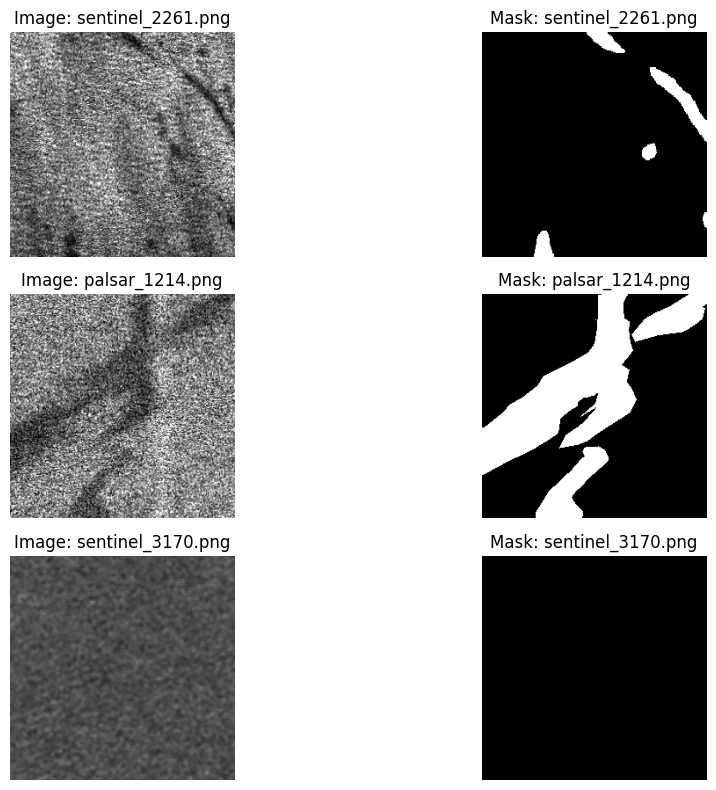

In [11]:
# Define paths
image_dir = "/content/oil_spill_dataset/images/images/train"
mask_dir = "/content/oil_spill_dataset/mask/masks/train"

# Get list of image filenames
image_files = os.listdir(image_dir)

# Pick 3 random images
sample_files = random.sample(image_files, 3)

# Plot each image with its mask
plt.figure(figsize=(12, 8))

for i, file_name in enumerate(sample_files):
    # Load image and mask
    img_path = os.path.join(image_dir, file_name)
    mask_path = os.path.join(mask_dir, file_name)

    image = Image.open(img_path).convert("RGB")
    mask = Image.open(mask_path)

    # Plot image
    plt.subplot(3, 2, 2*i + 1)
    plt.imshow(image)
    plt.title(f"Image: {file_name}")
    plt.axis("off")

    # Plot mask
    plt.subplot(3, 2, 2*i + 2)
    plt.imshow(mask, cmap="gray")
    plt.title(f"Mask: {file_name}")
    plt.axis("off")

plt.tight_layout()
plt.show()


IoU Score: 0.2149


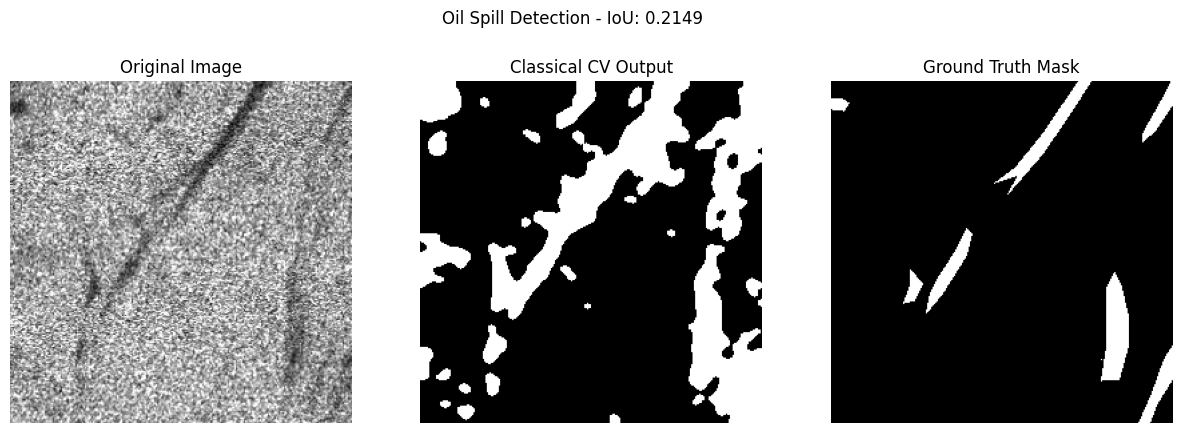

In [12]:
## Using classical CV approach

# --- Classical segmentation function ---
def simple_detect(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    eq = cv2.equalizeHist(img)
    blur = cv2.GaussianBlur(eq, (21,21), 0)
    _, th = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
    clean = cv2.morphologyEx(th, cv2.MORPH_OPEN, kernel, iterations=1)
    clean = cv2.morphologyEx(clean, cv2.MORPH_CLOSE, kernel, iterations=1)
    return cv2.bitwise_not(clean)

# --- Compute IoU ---
def compute_iou(pred_mask, true_mask):
    pred = pred_mask.astype(bool)
    true = true_mask.astype(bool)
    intersection = np.logical_and(pred, true).sum()
    union = np.logical_or(pred, true).sum()
    iou = intersection / union if union != 0 else 0
    return iou

# --- Example paths (change these to your actual dataset paths) ---
img_path = '/content/oil_spill_dataset/images/images/train/palsar_1225.png'
mask_path = '/content/oil_spill_dataset/mask/masks/train/palsar_1225.png'

# --- Run detection ---
pred_mask = simple_detect(img_path)
true_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

# --- Compute IoU ---
iou_score = compute_iou(pred_mask, true_mask)
print(f"IoU Score: {iou_score:.4f}")

# --- Plot results ---
fig, axs = plt.subplots(1, 3, figsize=(15,5))
axs[0].imshow(cv2.imread(img_path, cv2.IMREAD_GRAYSCALE), cmap='gray')
axs[0].set_title('Original Image')
axs[0].axis('off')

axs[1].imshow(pred_mask, cmap='gray')
axs[1].set_title('Classical CV Output')
axs[1].axis('off')

axs[2].imshow(true_mask, cmap='gray')
axs[2].set_title('Ground Truth Mask')
axs[2].axis('off')

plt.suptitle(f"Oil Spill Detection - IoU: {iou_score:.4f}")
plt.show()


In [13]:
print("For the computer vision baseleine method")

def simple_detect(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    eq = cv2.equalizeHist(img)
    blur = cv2.GaussianBlur(eq, (21, 21), 0)
    _, th = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    clean = cv2.morphologyEx(th, cv2.MORPH_OPEN, kernel, iterations=1)
    clean = cv2.morphologyEx(clean, cv2.MORPH_CLOSE, kernel, iterations=1)

    # Invert so oil is white
    return cv2.bitwise_not(clean)


# --- Compute IoU ---
def compute_iou(pred_mask, true_mask):
    pred = pred_mask.astype(bool)
    true = true_mask.astype(bool)
    intersection = np.logical_and(pred, true).sum()
    union = np.logical_or(pred, true).sum()
    return intersection / union if union != 0 else 0


# --- Paths ---
val_img_dir = "/content/oil_spill_dataset/images/images/val"
val_mask_dir = "/content/oil_spill_dataset/mask/masks/val"

# --- Loop through all validation images ---
iou_scores = []
file_names = sorted(os.listdir(val_img_dir))

for fname in tqdm(file_names, desc="Evaluating Validation Set"):
    img_path = os.path.join(val_img_dir, fname)
    mask_path = os.path.join(val_mask_dir, fname)

    if not os.path.exists(mask_path):
        continue  # Skip if mask missing

    pred_mask = simple_detect(img_path)
    true_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    # Ensure same size
    if pred_mask.shape != true_mask.shape:
        true_mask = cv2.resize(true_mask, (pred_mask.shape[1], pred_mask.shape[0]))

    iou = compute_iou(pred_mask, true_mask)
    iou_scores.append(iou)

# --- Mean IoU ---
mean_iou = np.mean(iou_scores)
print(f"\n✅ Mean IoU on Validation Set: {mean_iou:.4f}")

For the computer vision baseleine method


Evaluating Validation Set: 100%|██████████| 1615/1615 [00:07<00:00, 220.76it/s]


✅ Mean IoU on Validation Set: 0.5304


In [14]:
## Prepare data for training

# paths
BASE = "/content/oil_spill_dataset"
IMG_SRC = os.path.join(BASE, "images", "images", "train")
MASK_SRC = os.path.join(BASE, "mask", "masks", "train")

OUT = "/content/oil_spill_dataset_prepped"
os.makedirs(OUT, exist_ok=True)

for split in ["train","val","test"]:
    os.makedirs(os.path.join(OUT, "images", split), exist_ok=True)
    os.makedirs(os.path.join(OUT, "masks", split), exist_ok=True)

# list all image files (assuming masks have same filenames)
all_files = sorted([f for f in os.listdir(IMG_SRC) if f.lower().endswith(('.png','.jpg','.jpeg'))])
print("Total train images:", len(all_files))

# split - use 20% of the original train as validation; keep provided val as test later
train_files, val_temp = train_test_split(all_files, test_size=0.20, random_state=42)

# copy splits
for f in train_files:
    copy2(os.path.join(IMG_SRC, f), os.path.join(OUT, "images", "train", f))
    copy2(os.path.join(MASK_SRC, f), os.path.join(OUT, "masks", "train", f))

for f in val_temp:
    copy2(os.path.join(IMG_SRC, f), os.path.join(OUT, "images", "val", f))
    copy2(os.path.join(MASK_SRC, f), os.path.join(OUT, "masks", "val", f))

# copy the provided validation set as test (images/images/val and mask/masks/val)
PROVIDED_VAL_IMG = os.path.join(BASE, "images", "images", "val")
PROVIDED_VAL_MASK = os.path.join(BASE, "mask", "masks", "val")
provided_val_files = sorted([f for f in os.listdir(PROVIDED_VAL_IMG) if f.lower().endswith(('.png','.jpg'))])
for f in provided_val_files:
    copy2(os.path.join(PROVIDED_VAL_IMG, f), os.path.join(OUT, "images", "test", f))
    copy2(os.path.join(PROVIDED_VAL_MASK, f), os.path.join(OUT, "masks", "test", f))

print("Prepared folders under:", OUT)


Total train images: 6455
Prepared folders under: /content/oil_spill_dataset_prepped


In [15]:
## Making sure masks are 0/1

mask_dir = os.path.join(OUT, "masks", "train")
for fname in os.listdir(mask_dir):
    p = os.path.join(mask_dir, fname)
    m = Image.open(p).convert("L")
    arr = np.array(m)
    # threshold -> 0 or 255; assume white (255) is oil
    bin_arr = (arr > 127).astype('uint8') * 255
    Image.fromarray(bin_arr).save(p)

In [16]:
class SegDataset(Dataset):
    def __init__(self, img_dir, mask_dir, files, size=128):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.files = files
        self.size = size

        self.tf_img = T.Compose([
            T.Resize((size, size)),
            T.ToTensor(),
            T.Normalize([0.5], [0.5])
        ])

        self.tf_mask = T.Compose([
            T.Resize((size, size), interpolation=InterpolationMode.NEAREST),
            T.ToTensor()
        ])

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        f = self.files[idx]

        img = Image.open(os.path.join(self.img_dir, f)).convert("L")
        mask = Image.open(os.path.join(self.mask_dir, f)).convert("L")

        img = self.tf_img(img)
        mask = self.tf_mask(mask)

        mask = (mask > 0.5).float()  # binary mask

        return img, mask


In [17]:
train_files = sorted(os.listdir("/content/oil_spill_dataset_prepped/images/train"))
val_files = sorted(os.listdir("/content/oil_spill_dataset_prepped/images/val"))

train_ds = SegDataset("/content/oil_spill_dataset_prepped/images/train",
                      "/content/oil_spill_dataset_prepped/masks/train",
                      train_files, size=128)
val_ds = SegDataset("/content/oil_spill_dataset_prepped/images/val",
                    "/content/oil_spill_dataset_prepped/masks/val",
                    val_files, size=128)

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True, num_workers=2)
val_loader = DataLoader(val_ds, batch_size=16, shuffle=False, num_workers=2)


In [18]:
# Use ResNet34 as encoder backbone
model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",  # pretrained weights
    in_channels=1,               # grayscale input
    classes=1,                   # binary segmentation
)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/87.3M [00:00<?, ?B/s]

In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

# Assuming you already have:
# - train_loader, val_loader
# - your U-Net model: model
# - device

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)  # your U-Net

optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.BCEWithLogitsLoss()  # Binary segmentation

# IoU function (works with batch tensors)
def iou_score(pred, target, eps=1e-6):
    # pred: probabilities [0,1], target: binary
    pred = (pred > 0.5).float()
    inter = (pred * target).sum(dim=[1,2,3])
    union = ((pred + target) > 0).float().sum(dim=[1,2,3])
    return ((inter + eps) / (union + eps)).mean().item()

num_epochs = 15
print("Training U-Net:")

for epoch in range(num_epochs):
    # --- Training ---
    model.train()
    train_loss = 0

    for imgs, masks in train_loader:
        imgs, masks = imgs.to(device), masks.to(device)
        optimizer.zero_grad()

        preds = model(imgs)               # shape: (B,1,H,W)
        loss = criterion(preds, masks)    # BCE loss
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * imgs.size(0)

    train_loss /= len(train_loader.dataset)

    # --- Validation ---
    model.eval()
    val_loss = 0
    val_iou = 0

    with torch.no_grad():
        for imgs, masks in val_loader:
            imgs, masks = imgs.to(device), masks.to(device)
            preds = model(imgs)
            loss = criterion(preds, masks)
            val_loss += loss.item() * imgs.size(0)

            probs = torch.sigmoid(preds)          # convert logits to probabilities
            val_iou += iou_score(probs, masks) * imgs.size(0)

    val_loss /= len(val_loader.dataset)
    val_iou /= len(val_loader.dataset)

    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"train_loss: {train_loss:.4f} | val_loss: {val_loss:.4f} | val_iou: {val_iou:.4f}")


Training U-Net:
Epoch 1/15 | train_loss: 0.2643 | val_loss: 0.3666 | val_iou: 0.5870
Epoch 2/15 | train_loss: 0.2303 | val_loss: 0.2348 | val_iou: 0.6211
Epoch 3/15 | train_loss: 0.2149 | val_loss: 0.2267 | val_iou: 0.6377
Epoch 4/15 | train_loss: 0.2096 | val_loss: 0.1994 | val_iou: 0.6442
Epoch 5/15 | train_loss: 0.1999 | val_loss: 0.1798 | val_iou: 0.6608
Epoch 6/15 | train_loss: 0.1982 | val_loss: 0.1757 | val_iou: 0.6539
Epoch 7/15 | train_loss: 0.1853 | val_loss: 0.1790 | val_iou: 0.6614
Epoch 8/15 | train_loss: 0.1835 | val_loss: 0.1654 | val_iou: 0.6724
Epoch 9/15 | train_loss: 0.1846 | val_loss: 0.2524 | val_iou: 0.6146
Epoch 10/15 | train_loss: 0.1798 | val_loss: 0.1867 | val_iou: 0.6638
Epoch 11/15 | train_loss: 0.1762 | val_loss: 0.1595 | val_iou: 0.6752
Epoch 12/15 | train_loss: 0.1812 | val_loss: 0.1741 | val_iou: 0.6731
Epoch 13/15 | train_loss: 0.1763 | val_loss: 0.1722 | val_iou: 0.6748
Epoch 14/15 | train_loss: 0.1720 | val_loss: 0.1625 | val_iou: 0.6783
Epoch 15/15 |

In [20]:
test_ds = SegDataset("/content/oil_spill_dataset_prepped/images/test",
                     "/content/oil_spill_dataset_prepped/masks/test",
                     sorted(os.listdir("/content/oil_spill_dataset_prepped/images/test")),
                     size=128)

test_loader = DataLoader(test_ds, batch_size=16, shuffle=False, num_workers=2)


In [21]:
model.eval()
ious = []

with torch.no_grad():
    for imgs, masks in test_loader:
        imgs, masks = imgs.to(device), masks.to(device)

        # Forward pass
        preds = model(imgs)                  # logits
        preds = torch.sigmoid(preds)         # probabilities
        preds = (preds > 0.5).float()        # threshold to binary

        # Move to CPU & convert to numpy
        preds_np = preds.cpu().numpy().astype(np.uint8)  # (B,1,H,W)
        masks_np = masks.cpu().numpy().astype(np.uint8)  # (B,1,H,W)

        # Flatten for jaccard_score
        # Remove channel dimension if it exists
        if preds_np.shape[1] == 1:
            preds_np = preds_np[:,0,:,:]
            masks_np = masks_np[:,0,:,:]

        # Compute IoU per sample
        for p, m in zip(preds_np, masks_np):
            iou = jaccard_score(m.flatten(), p.flatten())
            ious.append(iou)

# Optionally remove zero IoU cases
ious_nonzero = [iou for iou in ious if iou > 0.0]

print("Mean IoU on test set:", np.mean(ious_nonzero))


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics

Mean IoU on test set: 0.7001107567896399


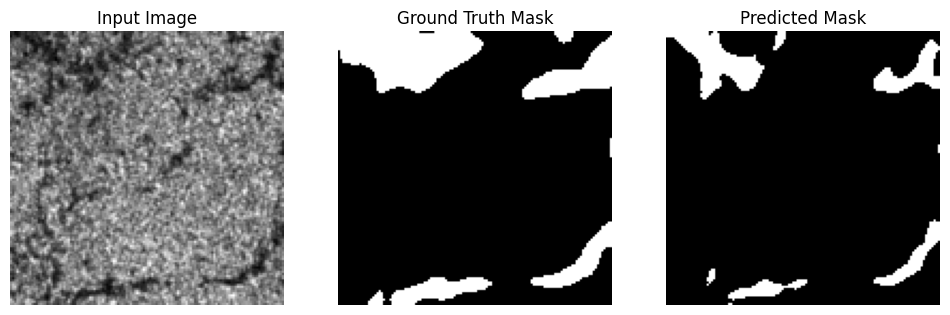

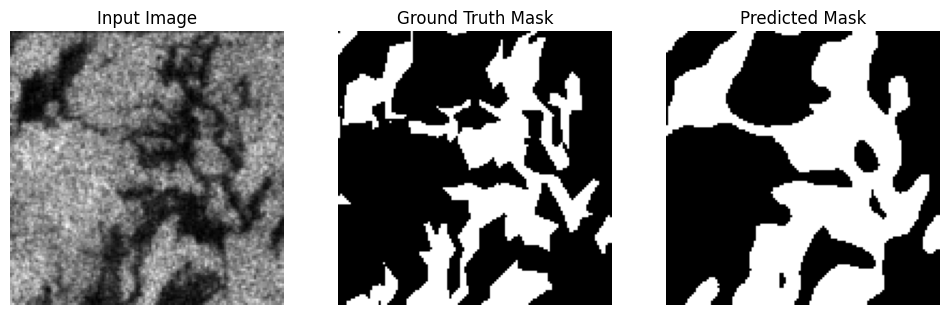

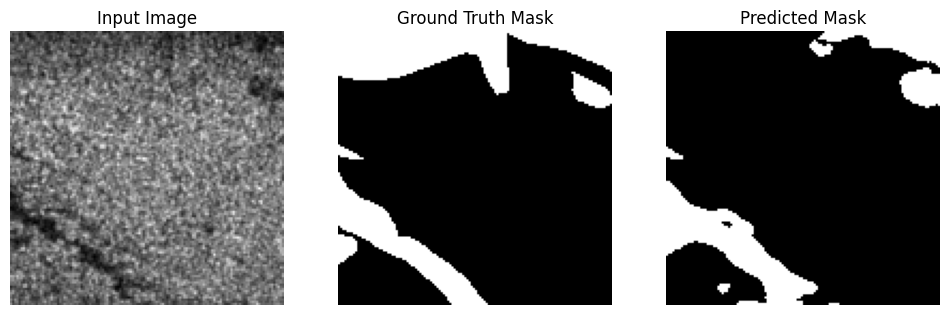

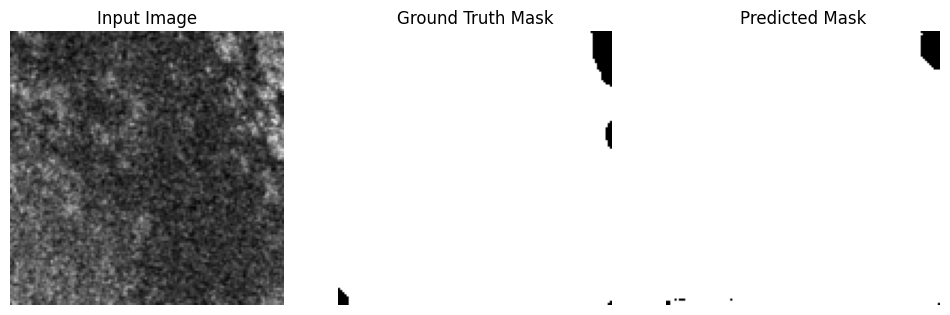

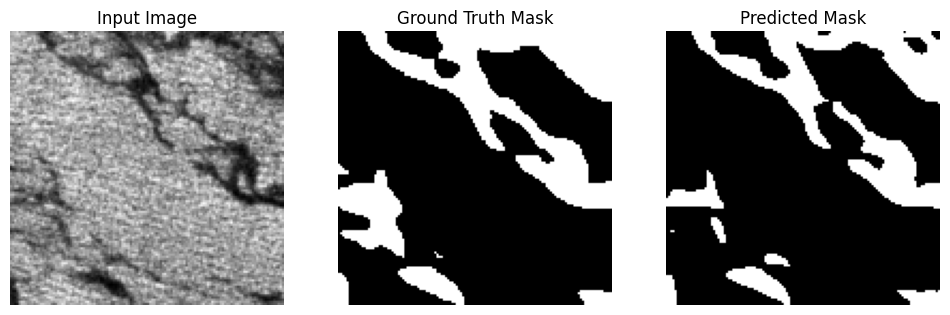

In [22]:
## View prediction

model.eval()

# Pick 5 random indices from the test dataset
indices = random.sample(range(len(test_loader.dataset)), 5)

with torch.no_grad():
    for idx in indices:
        img, mask = test_loader.dataset[idx]          # get single sample
        img_tensor = img.unsqueeze(0).to(device)      # add batch dim
        pred = model(img_tensor)                      # logits
        pred = torch.sigmoid(pred) > 0.5              # binary mask
        pred = pred.cpu().squeeze().numpy().astype(np.uint8)
        mask = mask.squeeze().numpy().astype(np.uint8)
        img = img.squeeze().numpy()                   # grayscale

        # Plot
        plt.figure(figsize=(12,4))
        plt.subplot(1,3,1)
        plt.imshow(img, cmap='gray')
        plt.title('Input Image')
        plt.axis('off')

        plt.subplot(1,3,2)
        plt.imshow(mask, cmap='gray')
        plt.title('Ground Truth Mask')
        plt.axis('off')

        plt.subplot(1,3,3)
        plt.imshow(pred, cmap='gray')
        plt.title('Predicted Mask')
        plt.axis('off')

        plt.show()


In [23]:
torch.save(model, "oil_spill_resnet.pth")

In [26]:
model.eval()  # set to evaluation mode
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

# Dummy input: match your model's input shape (B,C,H,W)
# For grayscale U-Net with 128x128 images:
dummy_input = torch.randn(1, 1, 128, 128).to(device)

onnx_path = "unet_oilspill.onnx"

torch.onnx.export(
    model,                   # model to export
    dummy_input,             # example input
    onnx_path,               # output file
    export_params=True,      # store trained weights
    opset_version=13,        # ONNX opset (>=11 is usually fine)
    do_constant_folding=True,# optimization
    input_names=['input'],   # name for input node
    output_names=['output'], # name for output node
    dynamic_axes={
        'input': {0: 'batch_size'},  # allow dynamic batch size
        'output': {0: 'batch_size'}
    }
)

print(f"ONNX model saved to {onnx_path}")


/tmp/ipython-input-2960368284.py:11: UserWarning: # 'dynamic_axes' is not recommended when dynamo=True, and may lead to 'torch._dynamo.exc.UserError: Constraints violated.' Supply the 'dynamic_shapes' argument instead if export is unsuccessful.
  torch.onnx.export(
W1221 12:30:46.246000 719 torch/onnx/_internal/exporter/_compat.py:114] Setting ONNX exporter to use operator set version 18 because the requested opset_version 13 is a lower version than we have implementations for. Automatic version conversion will be performed, which may not be successful at converting to the requested version. If version conversion is unsuccessful, the opset version of the exported model will be kept at 18. Please consider setting opset_version >=18 to leverage latest ONNX features


[torch.onnx] Obtain model graph for `Unet([...]` with `torch.export.export(..., strict=False)`...
[torch.onnx] Obtain model graph for `Unet([...]` with `torch.export.export(..., strict=False)`... ✅
[torch.onnx] Run decomposition...


Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/onnxscript/version_converter/__init__.py", line 127, in call
    converted_proto = _c_api_utils.call_onnx_api(
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/onnxscript/version_converter/_c_api_utils.py", line 65, in call_onnx_api
    result = func(proto)
             ^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/onnxscript/version_converter/__init__.py", line 122, in _partial_convert_version
    return onnx.version_converter.convert_version(
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/onnx/version_converter.py", line 39, in convert_version
    converted_model_str = C.convert_version(model_str, target_version)
                          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: /github/workspace/onnx/version_converter/BaseConverter.h:65: adapter_lookup: Assertion `false`

[torch.onnx] Run decomposition... ✅
[torch.onnx] Translate the graph into ONNX...
[torch.onnx] Translate the graph into ONNX... ✅
Applied 92 of general pattern rewrite rules.
ONNX model saved to unet_oilspill.onnx


In [27]:
import onnx

onnx_model = onnx.load(onnx_path)
onnx.checker.check_model(onnx_model)
print("ONNX model is valid!")


ONNX model is valid!
